In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
tf.test.is_gpu_available()

True

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

# **Dataset Loading**

In [5]:
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df['sentiment'] = [1 if sentiment == 'positive' else 0
                  for sentiment in df['sentiment']]
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Create Train set,Test set, and Validation

In [8]:
reviews = df['review'].values
sentiments = df['sentiment'].values

train_reviews = reviews[:30000]
train_sentiments = sentiments[:30000]

val_reviews = reviews[30000:35000]
val_sentiments = sentiments[30000:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((30000,), (5000,), (15000,))

### Text Wrangling

In [9]:
pip install contractions

     |████████████████████████████████| 321 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 260 kB 12.9 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=102851 sha256=c14605f90fb158dd533926a803eb8c0b5d4a920f1de6d230875073f3c262a0d9
  Stored in directory: /root/.cache/pip/wheels/fe/ea/e6/38b0d734be6936b783e916a0d8d670313fb1b2f74c5889d4fe
Successfully built pyahocorasick
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install beautifulsoup4

     |████████████████████████████████| 115 kB 2.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

In [12]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    document = strip_html_tags(document)
    document = document.lower()
    document = document.translate(document.maketrans("\n\t\r", "   "))
    document = remove_accented_chars(document)  
    document = expand_contractions(document)    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [13]:
train_reviews = pre_process_corpus(train_reviews)

In [14]:
train_reviews

array(['one of the other reviewers has mentioned that after watching just oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare for

In [15]:
val_reviews = pre_process_corpus(val_reviews)

In [16]:
test_reviews = pre_process_corpus(test_reviews)

### Data & Feature Engineering Pipeline Using numpy_input_fn()

In [17]:
#train input
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, 
    batch_size=256, num_epochs=None, shuffle=True)

predict_train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, shuffle=False)

predict_val_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': val_reviews}, val_sentiments, shuffle=False)

predict_test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': test_reviews}, test_sentiments, shuffle=False)


## Deep Learning Model for Encoder Feature

In [18]:
embedding_feature = hub.text_embedding_column(
    key='sentence',
    module_spec='https://tfhub.dev/google/universal-sentence-encoder/2',
    trainable=False)

## Deep Neural Network 

In [19]:
dnn = tf.estimator.DNNClassifier(
    hidden_units = [512, 128],
    feature_columns = [embedding_feature],
    n_classes=2,
    activation_fn=tf.nn.relu,
    dropout=0.1,
    optimizer = 'Adagrad',
    model_dir=None,
    weight_column=None
)


In [20]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Model Training

In [21]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import time

TOTAL_STEPS = 1500
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))



----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 65.16772174835205
Eval Metrics (Train): {'accuracy': 0.5508, 'accuracy_baseline': 0.5005, 'auc': 0.57627773, 'auc_precision_recall': 0.5681152, 'average_loss': 0.691762, 'label/mean': 0.5005, 'loss': 0.6917527, 'precision': 0.58733404, 'prediction/mean': 0.49712226, 'recall': 0.34465533, 'global_step': 100}
Eval Metrics (Validation): {'accuracy': 0.5424, 'accuracy_baseline': 0.505, 'auc': 0.5631036, 'auc_precision_recall': 0.55370927, 'average_loss': 0.6918173, 'label/mean': 0.495, 'loss': 0.6919244, 'precision': 0.5617162, 'prediction/mean': 0.49722275, 'recall': 0.3438384, 'global_step': 100}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 64.9319429397583
Eval Metrics (Train): {'accuracy': 0.5904667, 'accuracy_baseline': 0.5005, 'auc': 0.6375664, 'auc_p

Train Time (s): 59.16683506965637
Eval Metrics (Train): {'accuracy': 0.7442667, 'accuracy_baseline': 0.5005, 'auc': 0.82720226, 'auc_precision_recall': 0.819285, 'average_loss': 0.6762035, 'label/mean': 0.5005, 'loss': 0.67619115, 'precision': 0.7904438, 'prediction/mean': 0.49654153, 'recall': 0.66546786, 'global_step': 1200}
Eval Metrics (Validation): {'accuracy': 0.7432, 'accuracy_baseline': 0.505, 'auc': 0.81848675, 'auc_precision_recall': 0.8045703, 'average_loss': 0.67652136, 'label/mean': 0.495, 'loss': 0.6764447, 'precision': 0.77944624, 'prediction/mean': 0.4968774, 'recall': 0.6711111, 'global_step': 1200}

----------------------------------------------------------------------------------------------------
Training for step = 1200
Train Time (s): 59.4224009513855
Eval Metrics (Train): {'accuracy': 0.7489, 'accuracy_baseline': 0.5005, 'auc': 0.83156466, 'auc_precision_recall': 0.82330406, 'average_loss': 0.67463833, 'label/mean': 0.5005, 'loss': 0.67462575, 'precision': 0.7886

## Model Evaluation

In [22]:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.75666666,
 'accuracy_baseline': 0.5005,
 'auc': 0.8424139,
 'auc_precision_recall': 0.83489394,
 'average_loss': 0.6697232,
 'label/mean': 0.5005,
 'loss': 0.66970766,
 'precision': 0.7995186,
 'prediction/mean': 0.49589187,
 'recall': 0.6857809,
 'global_step': 1600}

In [23]:
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.7592,
 'accuracy_baseline': 0.5006667,
 'auc': 0.842605,
 'auc_precision_recall': 0.8363728,
 'average_loss': 0.6694599,
 'label/mean': 0.5006667,
 'loss': 0.66945595,
 'precision': 0.79719424,
 'prediction/mean': 0.4962148,
 'recall': 0.6961385,
 'global_step': 1600}

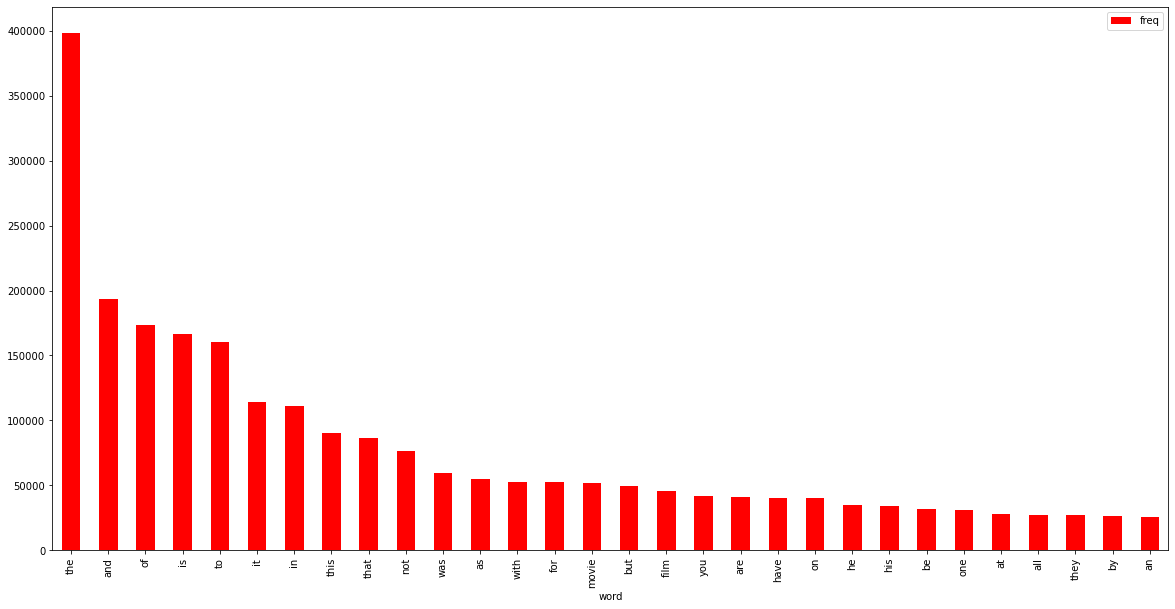

In [28]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
word_count = cv.fit_transform(train_reviews)
sum_word = word_count.sum(axis=0)
word_freq=[(word, sum_word[0, i]) for word, i in cv.vocabulary_.items()]
word_freq=sorted(word_freq, key=lambda x: x[1],reverse=True)

frequency = pd.DataFrame(word_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(20, 10), color='red')
plt.show()

In [29]:
frequency

,word,freq
0,the,398635
1,and,193632
2,of,173483
3,is,166594
4,to,160623
...,...,...
113258,stargazing,1
113259,balsmeyer,1
113260,sawasdee,1
113261,dormmates,1


AttributeError: module 'matplotlib.pyplot' has no attribute 'xlable'

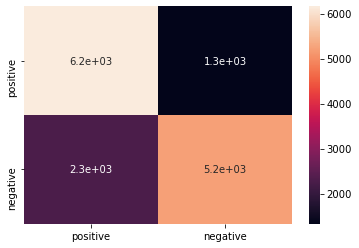

In [41]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]
    
# get model predictions on test data
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

import seaborn as sns

with tf.compat.v1.Session() as session:
    cm = tf.compat.v1.confusion_matrix(test_sentiments, predictions).eval()
    
labels = ['positive', 'negative']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
x = plt.xlabel('Prediction')
y = plt.ylabel('Actual')
plt.show()

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_sentiments,
                           y_pred=predictions, target_names=labels))

              precision    recall  f1-score   support

    positive       0.73      0.82      0.77      7490
    negative       0.80      0.70      0.74      7510

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000

